# The idea of this project is to compare the implementation of a CNN architecture and a Reinforcement Learning architecture for a classification problem, more precisely, we are trying to teach the models to play the Lunar Landing videogame (Atari 1979).

In [3]:
import numpy as np
import pandas as pd
import keras
import cv2
import os
import sys
import io
from imgaug import augmenters as iaa
import imgaug as ia
import skimage
from matplotlib import pyplot as plt
import tqdm
import random

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.utils import shuffle

from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint

import gym
from keras.models import Sequential
from keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

import lunar_lander_ml_images_player as ll

Using TensorFlow backend.


## First off we need to define a function for the preprocessing of our pictures, in our case, we will be only resizing the pictures and saving them on disk

In [151]:
def prepare_images(path_read, path_write):
    """1) Convert to grayscale, 2) Shrink, 3) Prepare groups of 4 frames??
    """
    filenames = os.listdir(path_read)
    for filename in tqdm.tqdm(filenames):
        # image in color
        image = cv2.imread(os.path.join(path_read,filename), 1) # parameter in imread: #1 = color, #0 = gray, #-1 = unchanged (alpha)
        resized_image = cv2.resize(image, (84, 84))
        cv2.imwrite(os.path.join(path_write, filename), resized_image)

In [152]:
prepare_images('LunarLanderFramesPart1/', 'transformed-frames')

100%|████████████████████████████████████████████████████████████████████████████| 63671/63671 [14:40<00:00, 89.13it/s]


## Transformation is complete, now, we will get the action related to each picture:

In [153]:
def get_actions(path_read, path_write):
    """Extract actions from file names (last digit before the extension)
        0 = None
        1 = Up
        2 = Left
        3 = Right
    """
    filenames = os.listdir(path_read)
    # extract action
    actions = [filename[-6] for filename in filenames]
    pd.DataFrame(actions, columns=['actions']).to_csv(path_write, index=False)
    return actions

In [154]:
if not os.path.isfile('csv/actions.csv'):
    get_actions('LunarLanderFramesPart1/', 'csv/actions.csv')

## Once we extract our actions, we proceed to check the distribution of the classes

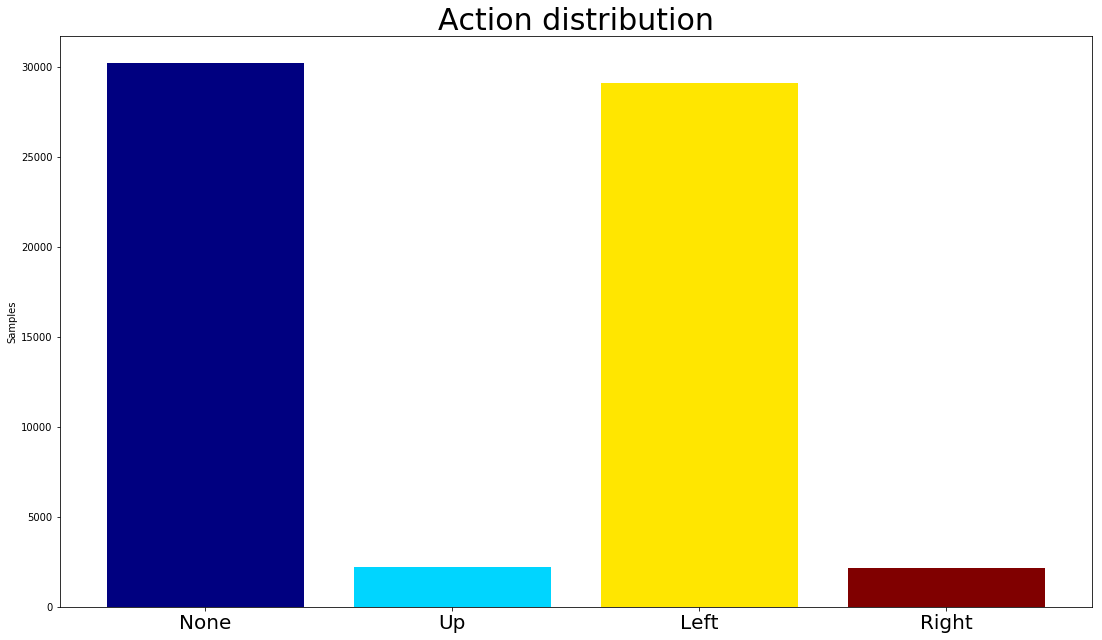

In [37]:
actions = pd.read_csv('csv/actions.csv')
count = actions.groupby('actions')['actions'].count()

n = len(count)
colors = plt.cm.jet(np.linspace(0, 1, n))

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.ylabel('Samples')
plt.bar(['None', "Up", "Left", "Right"], count, color=colors)
plt.xticks(fontsize =20)
plt.title("Action distribution", fontsize=30)
plt.show()

## Our classes are highly imbalanced, to fix this we will create new samples, these new samples will not be an exact copy of current frames (as implemented by the upsampling techniques), but instead will be an augmented version of them. First we calculate the imbalance ratio (i.e. if majority class has 10 samples, ratio= (10/samples from other classes)-1; then we use this ratio to define how many copies will be created from minority classes. 

In [156]:
def calculate_imbalance(path_read):
    """ Calculate samples of class with max samples, then compute the ratio
    between this value and the difference of the rest of the classes. Returns a dictionary {'class': ratio difference}
    """
    imbalance = {}
    filenames = os.listdir(path_read)
    # extract action
    actions = [filename[-6] for filename in filenames]
    # get number of samples of majority class
    count = pd.DataFrame(actions, columns=['actions']).groupby('actions')['actions'].count()
    max_ = count.max()
    #for each action
    for index in count.index:
        # how many times to reach max_ samples?
        imbalance[index] =  (max_  // count[index]) - 1
    print(imbalance)
    return imbalance

def fix_class_imbalance(path_read, path_write):
    """Classes are very unbalanced, fix them by augmenting the under represented classes
    path_read: string, path to images
    unbalanced: list, numeric value corresponding to unbalanced classes [0 = None, 1 = Up, 2 = Left, 3 = Right]
    """
    images = os.listdir(path_read)
    # read an image to extract image dimensions
    im = cv2.imread(os.path.join(path_read,images[0]), 1)# parameter in imread: #1 = color, #0 = gray, #-1 = unchanged (alpha)
    width, height, channels = im.shape
    
    # which classes are imbalanced?
    print("Calculating imbalances ratio...")
    imbalance = calculate_imbalance(path_read)
    imbalanced_filenames = []
    for i, image in enumerate(images):
        # select those files from imbalanced classes (all classes expect majority class)
        if imbalance[image[-6]] != 0:
            imbalanced_filenames.append(image)
    
    # multiply list by deficit ratio (imbalance)
    filtered_by_ratio = []
    print("Multiplying filenames by ratio imbalance...")
    for key in imbalance:
        # select files from same class
        filtered = [file for file in imbalanced_filenames if key +'.jpeg' in file]
        # append files times deficit value
        filtered_by_ratio.append(filtered*imbalance[key])
    # list of lists to a single list
    filtered_and_sorted = [item for sublist in filtered_by_ratio for item in sublist]
    
    # define numpy array place holder
    np_images = np.zeros(shape=(len(filtered_and_sorted),width,height, channels), dtype=np.uint8)
    print(np_images.shape)

    # read imbalanced files and save then in np array placeholder
    print("Reading images to transform...")
    for i, image in enumerate(filtered_and_sorted):
        np_images[i] = cv2.imread(os.path.join(path_read, image), 1) # parameter in imread: #1 = color, #0 = gray, #-1 = unchanged (alpha)
        
    ia.seed(1)
    # define transformations
    seq = iaa.Sequential(
        [
            iaa.Sometimes(0.2,iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))),
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
        ], random_order=True) # apply augmenters in random order
    
    print("Starting transformation...")
    images_aug = seq.augment_images(np_images)

    # save augmented images
    counter = 0
    print("Saving transformed files ...")
    for i, filename in enumerate(tqdm.tqdm(filtered_and_sorted)):
        if i > 0:
            # next file belongs to different class?
            if filtered_and_sorted[i-1][-6] != filename[-6]:
                counter = 0
        cv2.imwrite(path_write + str(counter).zfill(5) + '_' + filename[-6] + '.jpeg', images_aug[i])
        counter += 1

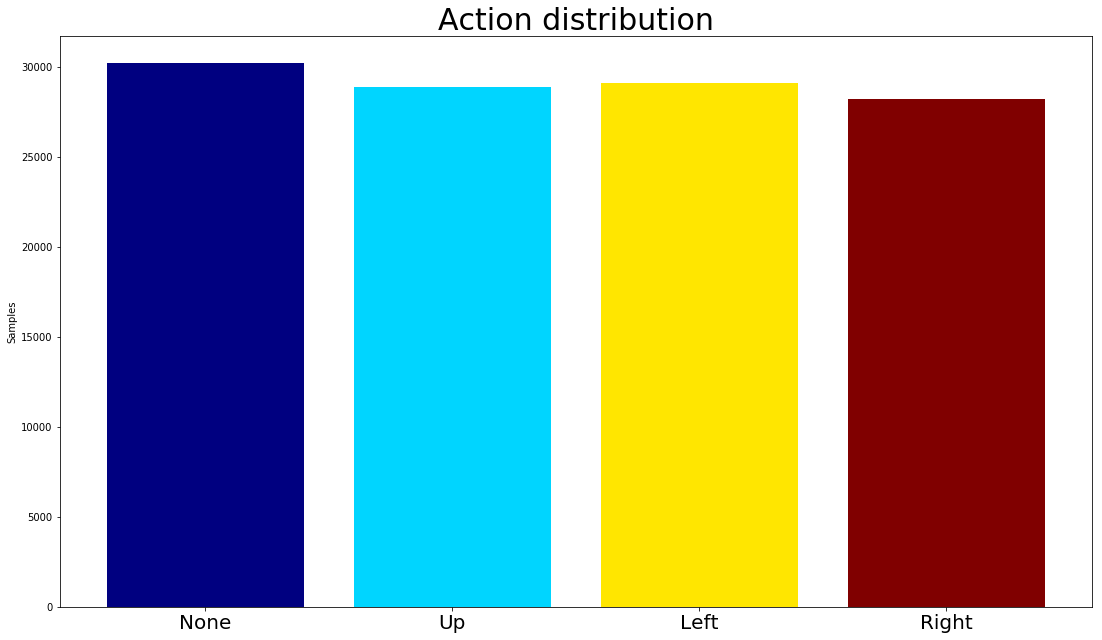

In [36]:
if not os.path.isfile('csv/actions_balanced.csv'):
    fix_class_imbalance('transformed-frames/', 'transformed-frames/')
    
if not os.path.isfile('csv/actions_balanced.csv'):
        get_actions('transformed-frames/', 'csv/actions_balanced.csv')
        actions = pd.read_csv('csv/actions_balanced.csv')
        count = actions.groupby('actions')['actions'].count()

        n = len(count)
        colors = plt.cm.jet(np.linspace(0, 1, n))

        fig = plt.figure()
        fig.set_size_inches(18.5, 10.5)
        plt.bar(['None', "Up", "Left", "Right"], count, color=colors)
        plt.ylabel('Samples')
        plt.xticks(fontsize =20)
        plt.title("Action distribution", fontsize=30)
        plt.show()

## We now have a more even distribution. Images have been saved on disk. Now, it's time to split and prepare our data for training.

In [4]:
def train_val_test(path_read_x, path_read_y):
    filenames = os.listdir(path_read_x)
    target = pd.read_csv(path_read_y)
    
    # here the X splits are filenames, y splits are actual class numbers
    X_train_val, X_test, y_train_val, y_test = train_test_split(filenames, target, random_state=0, test_size = 0.30, train_size = 0.7)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=0, test_size = 0.20, train_size = 0.8)
    
    # first image for placeholder
    image = cv2.imread(os.path.join(path_read_x,filenames[0]), 1)
    width, height, channel = image.shape
    
    # define placeholders
    X_train_np = np.zeros(shape = (len(X_train), width, height, channel ), dtype=np.uint8)
    X_val_np = np.zeros(shape = (len(X_val), width, height, channel ), dtype=np.uint8)
    X_test_np = np.zeros(shape = (len(X_test), width, height, channel), dtype=np.uint8)

    # fill up the placeholders
    for i, image in enumerate(tqdm.tqdm(X_train)):
        X_train_np[i] = cv2.imread(os.path.join(path_read_x,image), 1)
    
    for i, image in enumerate(tqdm.tqdm(X_val)):
        X_val_np[i] = cv2.imread(os.path.join(path_read_x,image), 1)
    
    for i, image in enumerate(tqdm.tqdm(X_test)):
        X_test_np[i] = cv2.imread(os.path.join(path_read_x,image), 1)


    # Convert class vectors to binary class matrices.
    num_classes = 4
    
    y_train_wide = keras.utils.to_categorical(y_train, num_classes)
    y_val_wide = keras.utils.to_categorical(y_val, num_classes)
    y_test_wide = keras.utils.to_categorical(y_test, num_classes)
    
    classes_num_label = dict()

    for idx, lbl in enumerate([0, 1, 2, 3]):
        classes_num_label[idx] = lbl
    
    return X_train_np, X_val_np, X_test_np, y_train_wide, y_val_wide, y_test_wide, y_train, y_val, y_test

In [184]:
X_train, X_val, X_test, y_train_w, y_val_w, y_test_w, y_train, y_val, y_test = train_val_test('transformed-frames/', 'csv/actions_balanced.csv')

100%|████████████████████████████████████████████████████████████████████████████| 34902/34902 [09:15<00:00, 62.83it/s]


## Split and preprocessing is finished, now let's preview some images from our training set

In [164]:
def preview_images():
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    fig.suptitle("Preview images", fontsize=20)
    
    nrow = 3
    ncol = 3
    action = ["none","up","left","right"]
    for i in range(1, 10):
        index = np.argwhere(y_train_w[i]==1)[0][0]
        ax = plt.subplot("33"+str(i))
        ax.set_title(action[index], fontsize=15)
        ax.imshow(X_train[i])

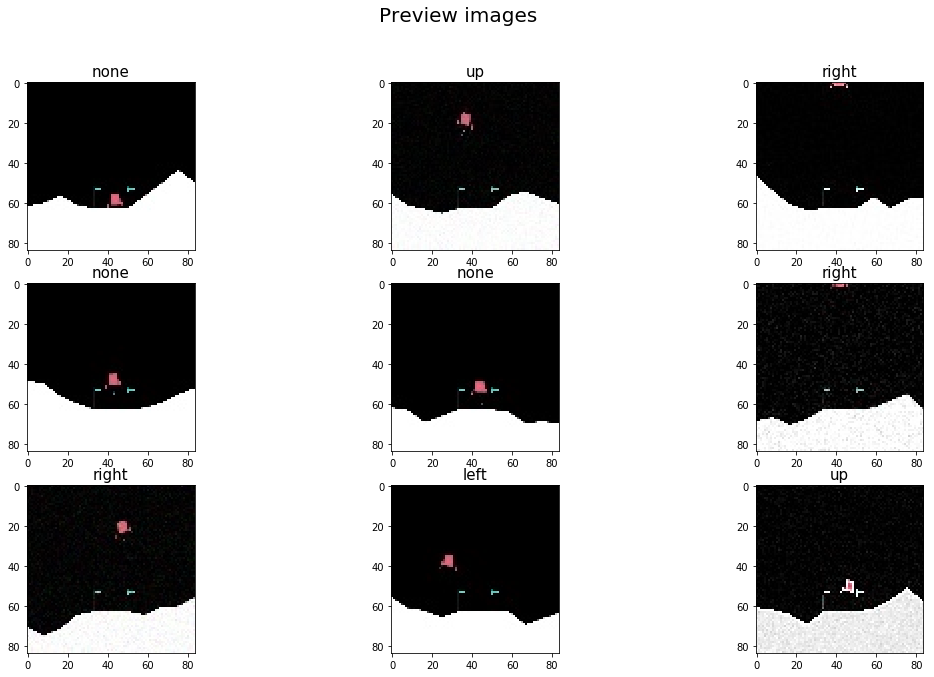

In [165]:
preview_images()

## Now, the cool part of the process, loading and building the VGG16 network. As we want to keep what the network has already learnt, we will freeze the weights up until the 17th layer, from there on we will train a dense layer with the features produced by feeding of our images through the frozen weights of VGG16.

In [174]:
def build_VGG16(neurons_lastlayer=256, activation='relu', dropout=0.5):
    """Loads the VGG16 network and modifies it so that a new dense layer on top is trainable
    """
    NUM_OF_CLASSES = 4
    
    width, height, channel = X_train[0].shape
    shape = (width, height, channel)
    # build the VGG16 network
    # network requires input shape to be a tuple of three numbers, channel numbers have to be three as well.
    vgg16_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = shape)
    display(vgg16_model.summary())
    vgg16_last_layer = vgg16_model.output

    # build a classifier model to put on top of the VGG16 model
    x1 = Flatten()(vgg16_last_layer)
    x2 = Dense(neurons_lastlayer, activation=activation)(x1)
    x3 = Dropout(dropout)(x2)
    final_layer = Dense(NUM_OF_CLASSES, activation = 'softmax')(x3)

    # Assemble the full model out of both parts
    full_model = keras.Model(vgg16_model.input, final_layer)

    # set the first 17 layers (up to the last conv block) to non-trainable (weights will not be updated)
    for layer in full_model.layers[:17]:
        layer.trainable = False

    # compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.SGD(lr=1e-4, momentum=0.9),
                  metrics=['accuracy'])

    full_model.summary()
    return full_model
    

In [175]:
full_model = build_VGG16()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 84, 84, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 84, 84, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 84, 84, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 42, 42, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 42, 42, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 42, 42, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 21, 21, 128)       0         
__________

None

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 84, 84, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 84, 84, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 84, 84, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 42, 42, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 42, 42, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 42, 42, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 21, 21, 128)       0         
__________

## The model is loaded and ready to be trained. Now, we setup fitting scheme, we will use checkpoints to callback to the best set of parameters once training is done.

In [180]:
batch_size = 128
epochs = 100

# Set up the callback to save the best model based on validaion data - notebook 2.2 needs to be run first.
best_weights_filepath = 'weights/best_weights.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss", save_best_only=True, save_weights_only=False)

history = full_model.fit(X_train, y_train_w, batch_size=batch_size, epochs=epochs, 
                         verbose = 1, validation_data=(X_val, y_val_w), shuffle=True, callbacks=[mcp])

#reload best weights
full_model.load_weights(best_weights_filepath)

## Training is finished, let's look at the loss graphs for the training and validation sets.

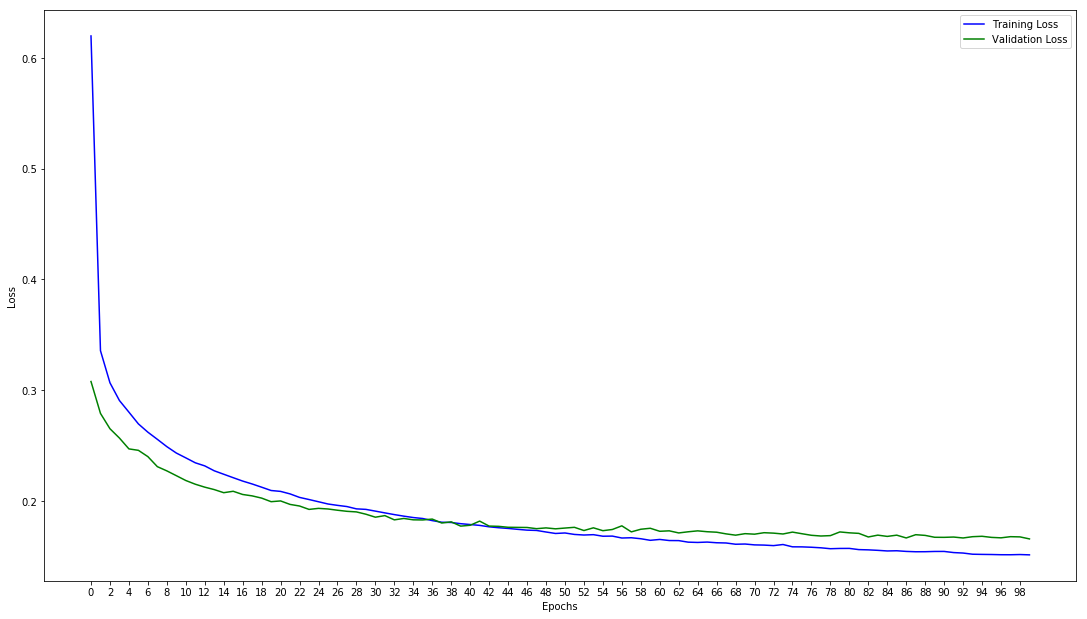

In [182]:
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

## But, how well did our model do? Not so great, class 2 is too low on precision, we can see the miss classification in our confussion matrix, it could not learn to differentiate well between class 0 and class 2.

In [185]:
# Make a set of predictions for the validation data
pred = np.argmax(full_model.predict(X_val),axis=1)

# Print performance details
print(metrics.classification_report(y_val, pred))

print("Confusion matrix")
print(metrics.confusion_matrix(y_val, pred))

              precision    recall  f1-score   support

           0       0.90      0.63      0.74      4139
           1       0.97      0.93      0.95      4041
           2       0.67      0.94      0.78      4130
           3       0.97      0.92      0.95      3978

   micro avg       0.85      0.85      0.85     16288
   macro avg       0.88      0.85      0.85     16288
weighted avg       0.88      0.85      0.85     16288

Confusion matrix
[[2595   27 1498   19]
 [  44 3741  198   58]
 [ 202   31 3876   21]
 [  41   39  221 3677]]


## Some examples of good and bad predictions:

In [294]:
def preview_images(mode='correct'):
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    nrow = 3
    ncol = 3
    action = ["none","up","left","right"]
    
    if mode == 'correct':
    
        correct_prediction = []
        index_correct = []
        i = 0
    
        while (len(correct_prediction)<10):
            if pred[i] == y_val.values[i][0]:
                # class
                correct_prediction.append(y_val.values[i][0])
                # index of class stored
                index_correct.append(i)
            i += 1
    
    if mode == 'incorrect':
    
        correct_prediction = []
        index_correct = []
        i = 0
    
        while (len(correct_prediction)<10):
            if pred[i] != y_val.values[i][0]:
                # class
                correct_prediction.append(y_val.values[i][0])
                # index of class stored
                index_correct.append(i)
            i += 1
        
    for i in range(1,10):
        index = correct_prediction[i]
        ax = plt.subplot("33"+str(i))
        ax.set_title(action[index], fontsize=15)
        ax.imshow(X_val[index_correct[i]])

    fig.suptitle("Preview "+ mode +" predictions", fontsize=20)

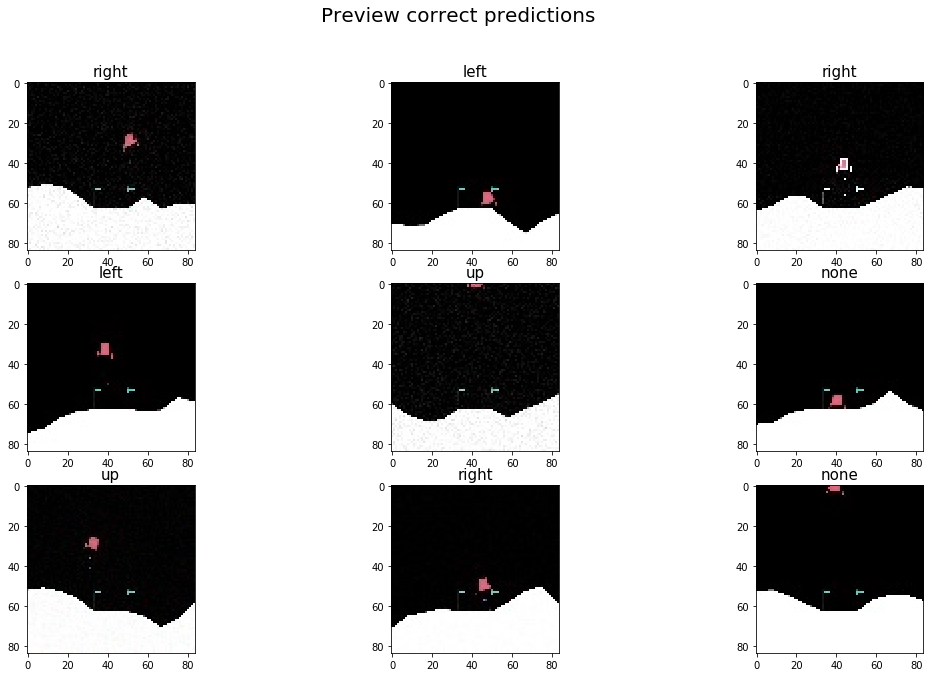

In [295]:
preview_images('correct')

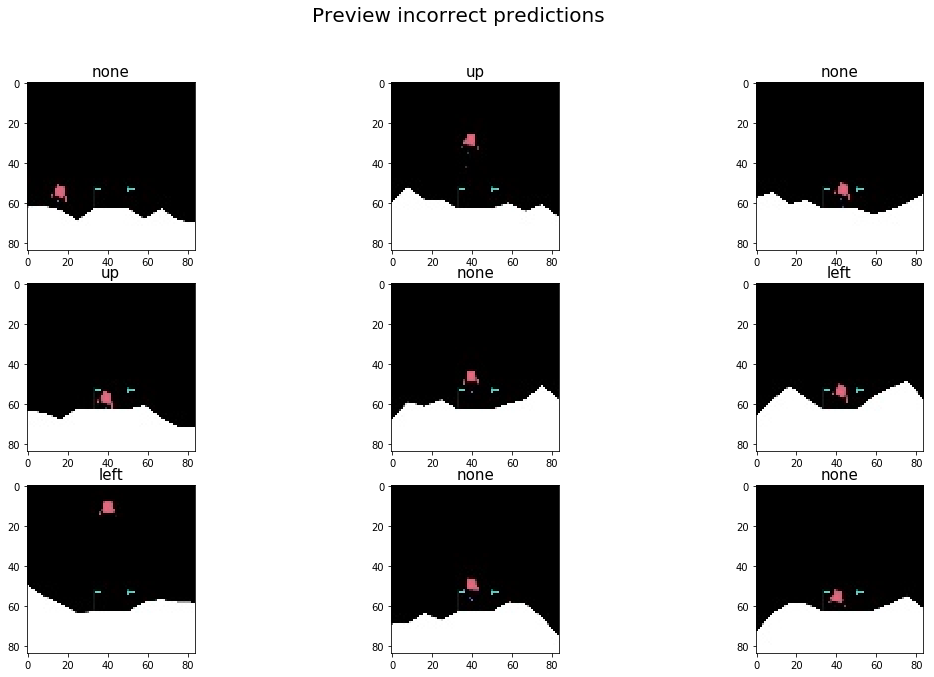

In [297]:
preview_images('incorrect')

# Reinforcement Learning Section

## Instantiate the Lunar Lander environment, build the network and train it. At the end, test the agent with the learnt parameters.

In [2]:
def load_rl_architecture():
    
    ENV_NAME = 'LunarLander-v2'
    
    # Get the environment and extract the number of actions.
    env = gym.make(ENV_NAME)
    np.random.seed(123)
    env.seed(123)
    nb_actions = env.action_space.n

    # Next, we build a very simple model.
    model = Sequential()
    model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dense(30))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(nb_actions))
    model.add(Activation('linear'))
    print(model.summary())

    # Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
    # even the metrics!
    memory = SequentialMemory(limit=50000, window_length=1)
    policy = BoltzmannQPolicy()
    dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
                   target_model_update=1e-2, policy=policy)
    dqn.compile(Adam(lr=1e-3), metrics=['mae'])
    return dqn, env

In [24]:
dqn, env = load_rl_architecture()
ENV_NAME = 'LunarLander-v2'
# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
dqn.fit(env, nb_steps=100000, visualize=True, verbose=2)

# After training is done, we save the final weights.
dqn.save_weights('weights/dqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# Finally, evaluate our algorithm for 50 episodes.
dqn.test(env, nb_episodes=50, visualize=True)


c:\users\ruben\docume~1\ucd\18-19_~2\comp47~1\ml_env\lib\site-packages\rl\memory.py:39: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


## It is seems to be doing ok, no negative rewards. Now, let's compare the performance of each model, that is, the CNN model and the RL model, and see which one performs better:

In [2]:
def test_cnn_model(path_write):
    """Test CNN and RL model
    cnn_model: boolean, if true, CNN model is tested, else, RL is tested
    
    NOTE: some modifications on the code below have been implemented, as my CNN training required color 
    images because I implemented a transfer learning strategy (the VGG16 network requires an image 
    shape of (widh, height, channels =3))
    """
    path = "weights/best_weights.hdf5"
    
    # Load the Lunar Lander environment
    env = ll.LunarLander()

    # Load and initialise the contrll model
    ROWS = 84
    COLS = 84
    CHANNELS = 3 # this set from 1 to 3
    model = keras.models.load_model(path)

    total_rewards = []

    for i in range(0, 200):
        s = env.reset()

        # Run the game loop
        total_reward = 0
        steps = 0
        while True:

            # Access the rednered scrnen image
            raw_image = env.render(mode='rgb_array')
            # Prepare the image for presentation to the network
            processed_image = cv2.resize(raw_image, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)
            # this now reads color images:
            processed_image = cv2.cvtColor(processed_image, 1)
            processed_image = np.array(processed_image, dtype=np.float)
            # changed the order of reshaping:
            processed_image = processed_image.reshape((1, ROWS, COLS, CHANNELS))
            processed_image = processed_image/255

            # Get the model to make a prediction
            # my model did not have predict_classes, I am using predict and extracting the action manually 
            a = model.predict(processed_image)
            a = np.argmax(a)

            # Step on the game
            s, r, done, info = env.step(a)
            env.render()
            total_reward += r
            if steps % 20 == 0 or done:
                print(["{:+0.2f}".format(x) for x in s])
                print("step {} total_reward {:+0.2f}".format(steps, total_reward))
                steps += 1
                if done: 
                    total_rewards.append(total_reward)
                    break

        print("total rewards", total_rewards)
        print("average total reward", np.mean(total_rewards))

    # Write total rewards to file
    pd.DataFrame(total_rewards, columns=['total_rewards']).to_csv(path_write, index=False)

In [3]:
test_cnn_model('csv/total_rewards_cnn.csv')

['-0.00', '+0.95', '-0.04', '+0.15', '+0.00', '+0.01', '+0.00', '+0.00']
step 0 total_reward +2.21
['+1.01', '+8.43', '+1.42', '+4.38', '-0.29', '-0.02', '+0.00', '+0.00']
step 1 total_reward -1383.04
total rewards [-1383.0444726947976]
average total reward -1383.0444726947976
['-0.01', '+0.93', '-0.46', '-0.23', '+0.01', '+0.10', '+0.00', '+0.00']
step 0 total_reward -1.21
['-0.35', '-0.01', '-0.79', '-0.49', '+0.17', '-3.80', '+0.00', '+0.00']
step 1 total_reward -145.16
total rewards [-1383.0444726947976, -145.16366348138553]
average total reward -764.1040680880916
['+0.01', '+0.93', '+0.61', '-0.26', '-0.01', '-0.12', '+0.00', '+0.00']
step 0 total_reward -0.58
['+1.00', '+0.79', '+2.29', '+0.55', '-0.62', '-0.16', '+0.00', '+0.00']
step 1 total_reward -377.53
total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343]
average total reward -635.2447120303725
['+0.00', '+0.95', '+0.06', '+0.21', '-0.00', '-0.01', '+0.00', '+0.00']
step 0 total_reward +2.09
['+0.06',

['-0.02', '+0.95', '-0.77', '+0.44', '+0.02', '+0.17', '+0.00', '+0.00']
step 0 total_reward -0.14
['-0.94', '+0.01', '-1.33', '-0.31', '+1.10', '+6.53', '+0.00', '+1.00']
step 1 total_reward -308.18
total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464]
average total reward -333.67951467921023
['+0.01', '+0.95', '+0.54', '+0.43', '-0.01', '-0.12', '+0.00', '+0.00']
step 0 total_reward +0.42
['+1.02', '+2.66', '+2.12', '+1.

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929]
average total reward -325.6850358852027
['-0.01', '+0.93', '-0.

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

['-0.01', '+0.95', '-0.58', '+0.38', '+0.01', '+0.13', '+0.00', '+0.00']
step 0 total_reward +0.27
['-0.94', '-0.00', '-1.84', '-0.48', '+0.26', '+0.82', '+1.00', '+0.00']
step 1 total_reward -244.70
total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

['-1.01', '+1.78', '-2.14', '+1.11', '+0.63', '+0.18', '+0.00', '+0.00']
step 1 total_reward -468.29
total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -11

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

total rewards [-1383.0444726947976, -145.16366348138553, -377.5259999149343, -95.64336652943265, -94.10508990720191, -468.27238667785053, -224.61374139752314, -381.7989927702085, -364.0190928827014, -589.6562216272889, -173.07809504847995, -179.62829142972834, -335.381383756353, -235.78200773178108, -101.61323189355878, -304.94210886137114, -412.45309798144507, -291.6816726897828, -80.36467142554119, -407.429415051316, -299.70759852729367, -326.5535700432572, -194.89738023556842, -230.0299658668639, -402.73405413281273, -541.8541640946266, -550.6098706221226, -356.60662083088647, -153.01781992604725, -308.1773923441464, -581.7257226946006, -141.86556122625834, -326.00317330050405, -159.52099361814987, -656.4171785117853, -250.72072660041118, -90.84751778918587, -201.58558769644648, -368.93088231479646, -427.39586177156315, -126.6983051141546, -611.8558814908279, -360.95994757675567, -119.61917555408162, -221.2946591982929, -41.164164117808184, -332.2559150033759, -168.73457861794503, -

## Apparently, it did not do very well.. total average reward of  ~ -333. Now lest's test the RL model:

In [3]:
def test_rl_model(path_write):
    
    dqn, env = load_rl_architecture()
    
    ENV_NAME = 'LunarLander-v2'
    # After training is done, we save the final weights.
    dqn.load_weights('weights/dqn_{}_weights.h5f'.format(ENV_NAME))

    # Redirect stdout to capture test results
    old_stdout = sys.stdout
    sys.stdout = mystdout = io.StringIO()

    # Evaluate our algorithm for a few episodes.
    dqn.test(env, nb_episodes=200, visualize=False)

    # Reset stdout
    sys.stdout = old_stdout

    results_text = mystdout.getvalue()

    # Print results text
    print("results")
    print(results_text)

    # Extact a rewards list from the results
    total_rewards = list()
    for idx, line in enumerate(results_text.split('\n')):
        if idx > 0 and len(line) > 1:
            reward = float(line.split(':')[2].split(',')[0].strip())
            total_rewards.append(reward)

    # Print rewards and average	
    print("total rewards", total_rewards)
    print("average total reward", np.mean(total_rewards))

    # Write total rewards to file
    pd.DataFrame(total_rewards, columns=['total_rewards']).to_csv(path_write, index=False)

In [4]:
test_rl_model('csv/total_rewards_rl.csv')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                450       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1530      
_________________________________________________________________
activation_2 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                496       
_________________________________________________________________
activation_3 (Activation)    (None, 16)                0         
__________


total rewards [219.153, 166.51, 266.119, 227.089, 258.633, 135.572, 140.686, 189.608, 240.697, 140.898, 160.505, 237.987, 217.463, 234.916, 260.152, 245.117, 124.891, 159.092, 230.486, 132.197, 243.905, 111.498, 136.719, 127.297, 139.298, 241.274, 250.29, 119.206, 210.798, 129.023, 264.661, 213.194, 153.118, 258.895, 143.29, 249.713, 232.084, 135.741, 150.57, 266.216, 274.241, 264.066, 113.229, 120.937, 267.269, 145.203, 170.078, 234.344, 176.018, 254.139, 227.608, 130.517, 135.777, 246.988, 132.186, 160.685, 227.856, 223.777, 233.604, 226.882, 116.718, 222.959, 227.326, 252.507, 243.967, 147.695, 244.034, 122.065, 196.548, 161.049, 158.887, 218.071, 135.514, 114.051, 218.515, 269.828, 204.227, 145.54, 157.584, 110.929, 235.448, 237.522, 136.662, 131.368, 223.492, 160.442, 119.872, 141.527, 241.581, 229.512, 253.432, 149.47, 37.354, 239.786, 239.03, 114.412, 233.919, 187.111, 159.019, 281.608, 72.914, 142.076, 116.147, 185.129, 114.767, 250.823, 87.921, 229.138, -781.948, 145.395, 228

## It did much better, ~181 total averaged reward, let's compare episode by episode.

## Finally let's compare the results!!

In [57]:
def compare_results(path_read, path_write):
    
    rl_results = pd.read_csv(os.path.join(path_read,'total_rewards_rl.csv'))
    cnn_results = pd.read_csv(os.path.join(path_read,'total_rewards_cnn.csv'))
    
    mean_rl = [np.sum(rl_results)/len(rl_results)]*len(rl_results)
    mean_cnn = [np.sum(cnn_results)/len(cnn_results)]*len(cnn_results)
    
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.plot(rl_results, 'blue', label='RL reward')
    plt.plot(cnn_results, 'green', label='CNN reward')
    plt.plot(mean_rl, label='RL mean reward')
    plt.plot(mean_cnn, label='CNN mean reward')
    plt.xticks(range(0,200)[0::10])
    plt.legend()
    plt.savefig(path_write, dpi=300)
    

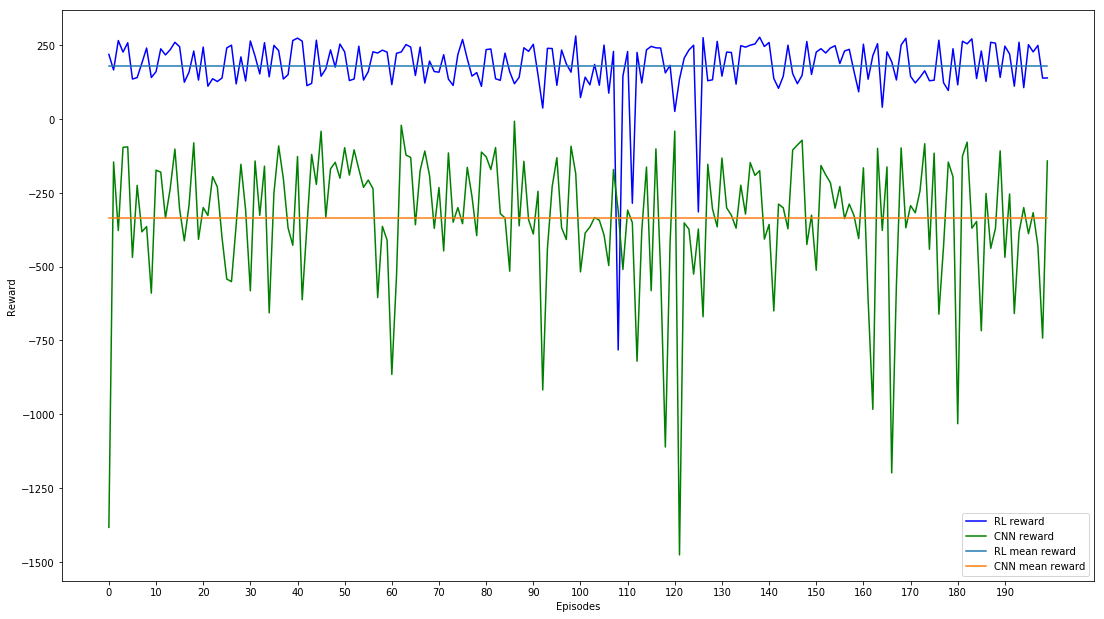

In [58]:
compare_results('csv/','results.png')

# Conclussions:

# Surprisingly enough, we can clearly see how the RL strategy out performs the CNN strategy by a huge margin. In retrospective it makes sense, as the CNN is learning the mapping function from static images, which could be an ok strategy if we had a distribution of images that could capture a sense of the whole space, we surely added more images to fix our class imbalance, however these images were more of the same frames. Another thing that captured my interest was the disk space each of the models required, RL = 33 kb, CNN = 70 Mb, very impresive, we can see here how different architectures/strategies work better for specific tasks. On top of this, the training for the CNN took around three hours to finish, and for the RL it took around 20 minutes.